# Dataset Friuli-Venezia Giulia
Registrazione delle misure combinate di ARPA, ISAC e SCIA. Si è visto che le differenze tra serie provenienti dalla stessa stazione (SCIA - ISAC) hanno un leggero bias positivo sia in T_MIN che in T_MAX, mentre quelle (MERGED - ARPA) negativo.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) di SCIA su ISAC, poi del MERGED su ARPA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset_id <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/FVG/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/FVG/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == "Friuli Venezia Giulia")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [11]:
daily_dataset <- load_daily_data.arpafvg() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2106923,112.6,3912102,209.0,NA,3912102,209
Vcells,3663630,28.0,16908558,129.1,16384,16906781,129


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [12]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2200296,117.6,3912102,209.0,NA,3912102,209.0
Vcells,4486471,34.3,20370269,155.5,16384,20344744,155.3


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

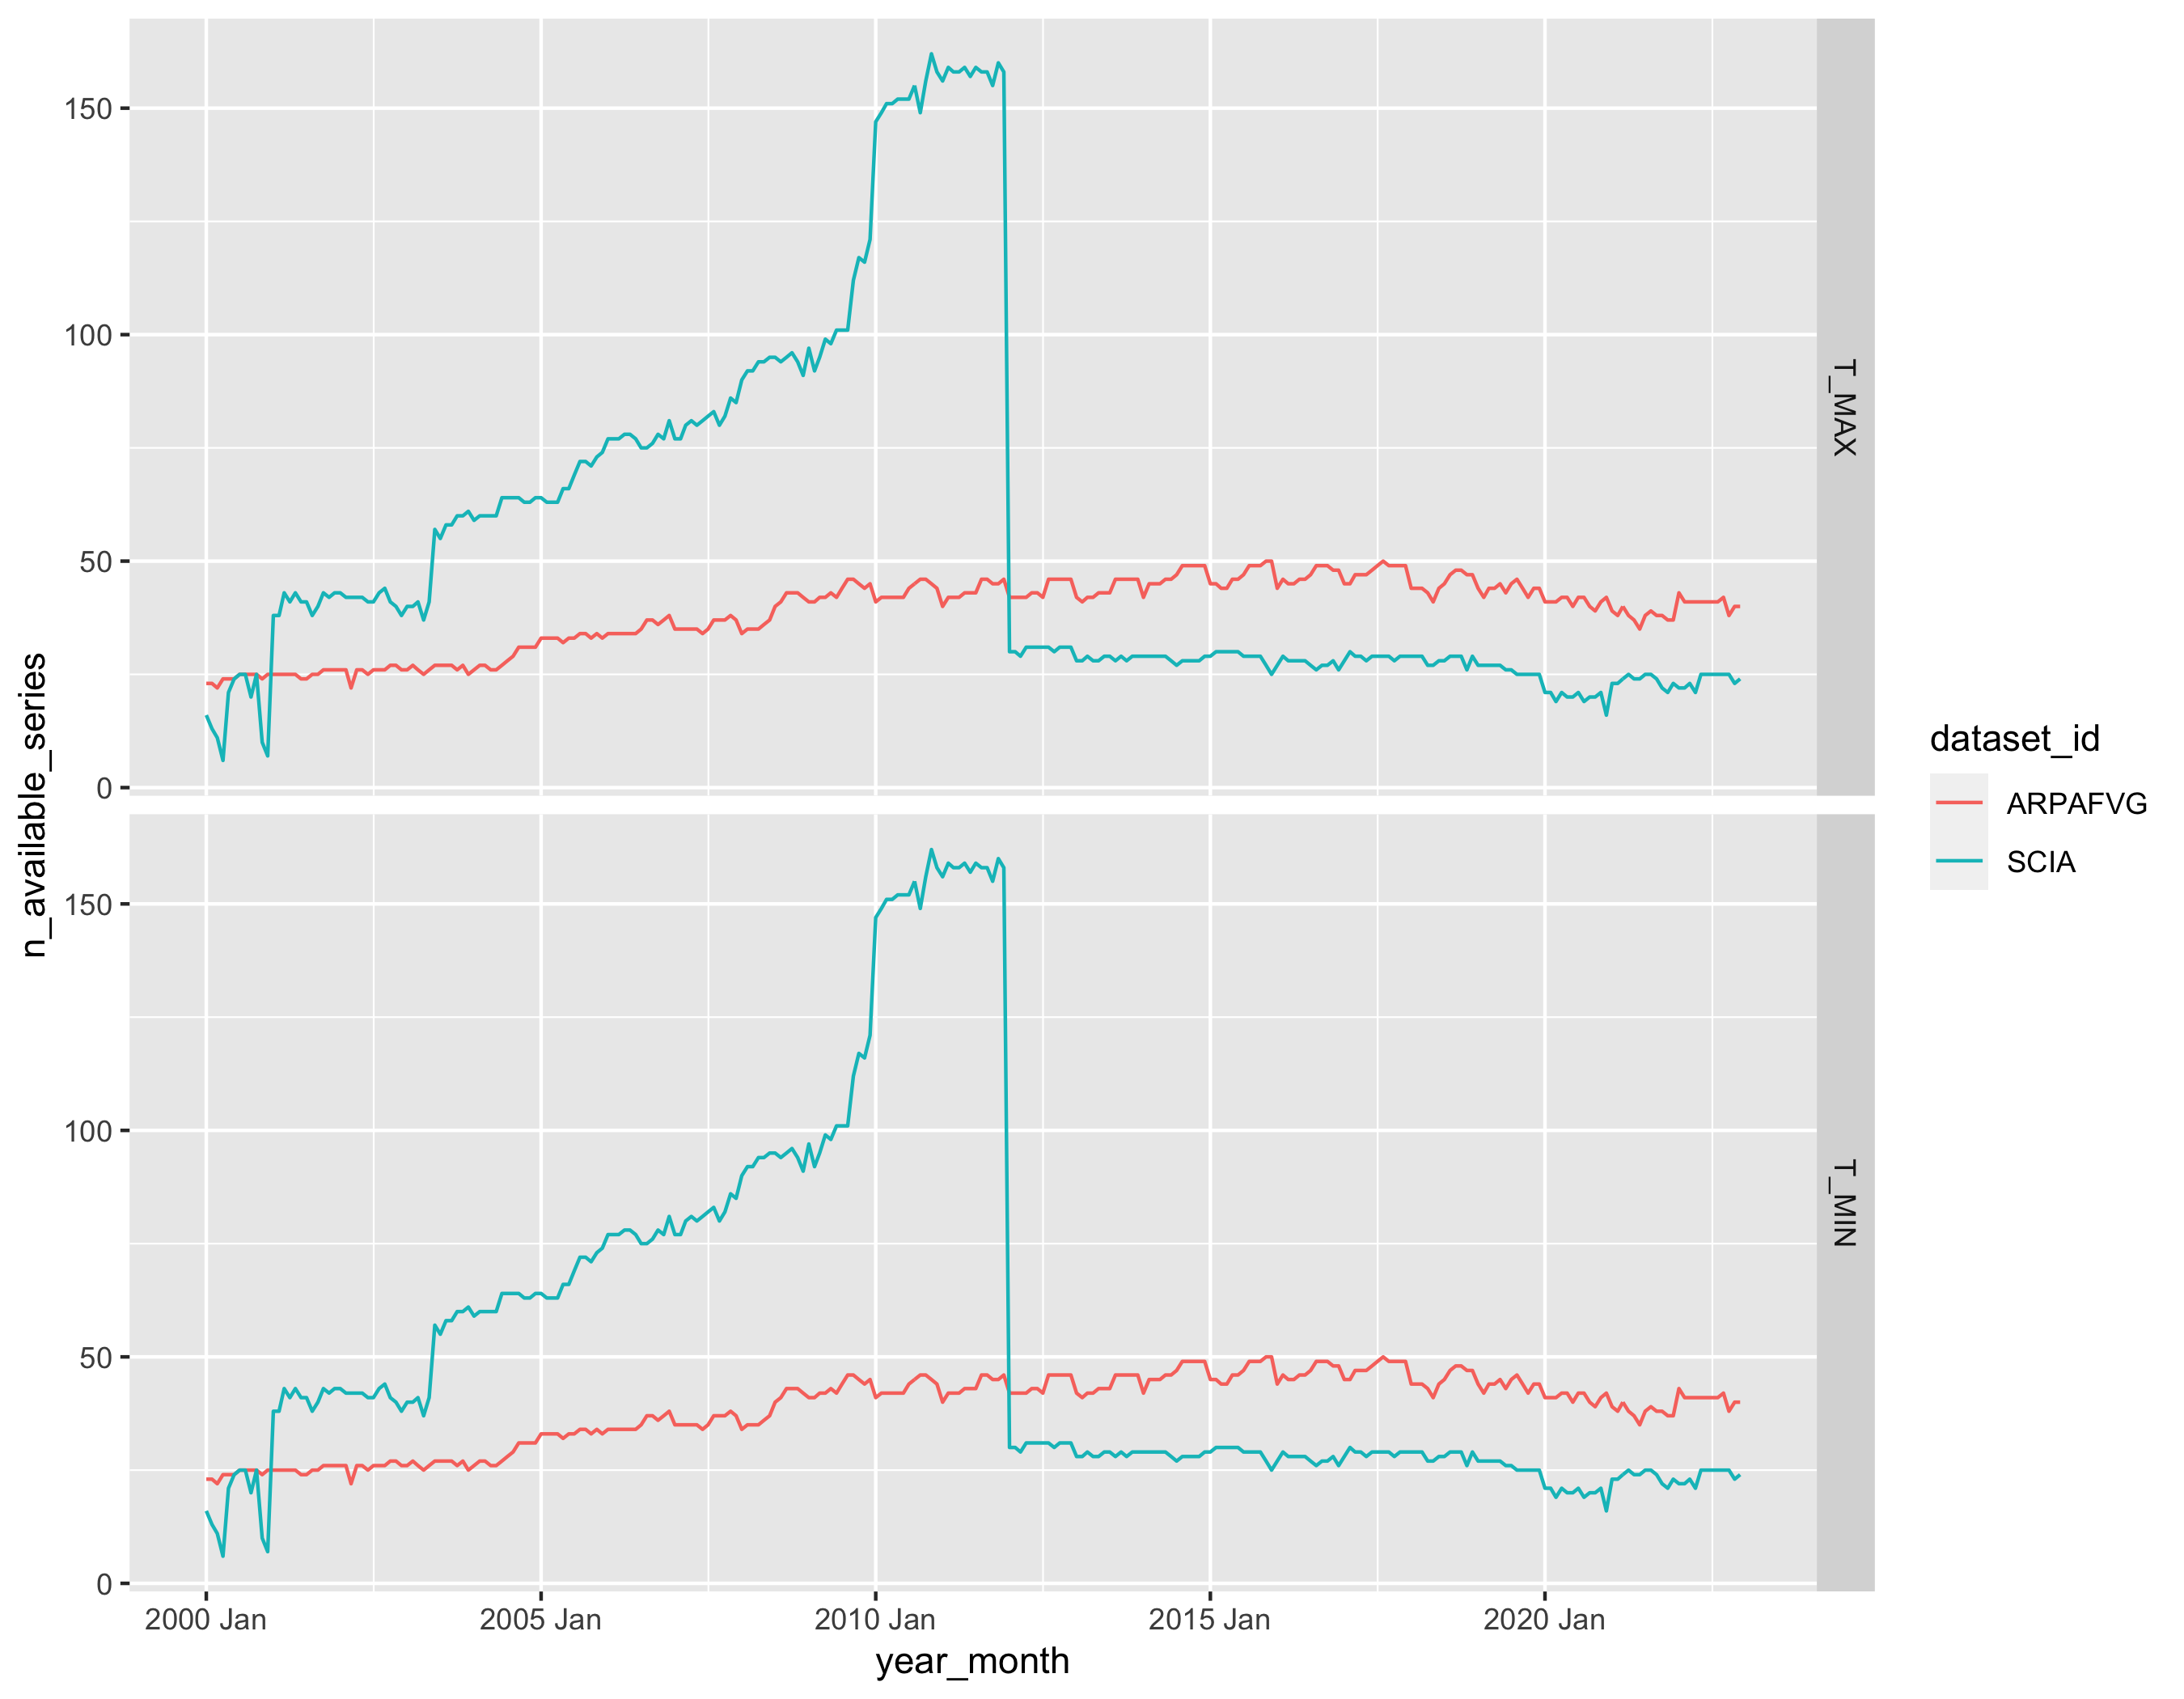

In [13]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = "SCIA",
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


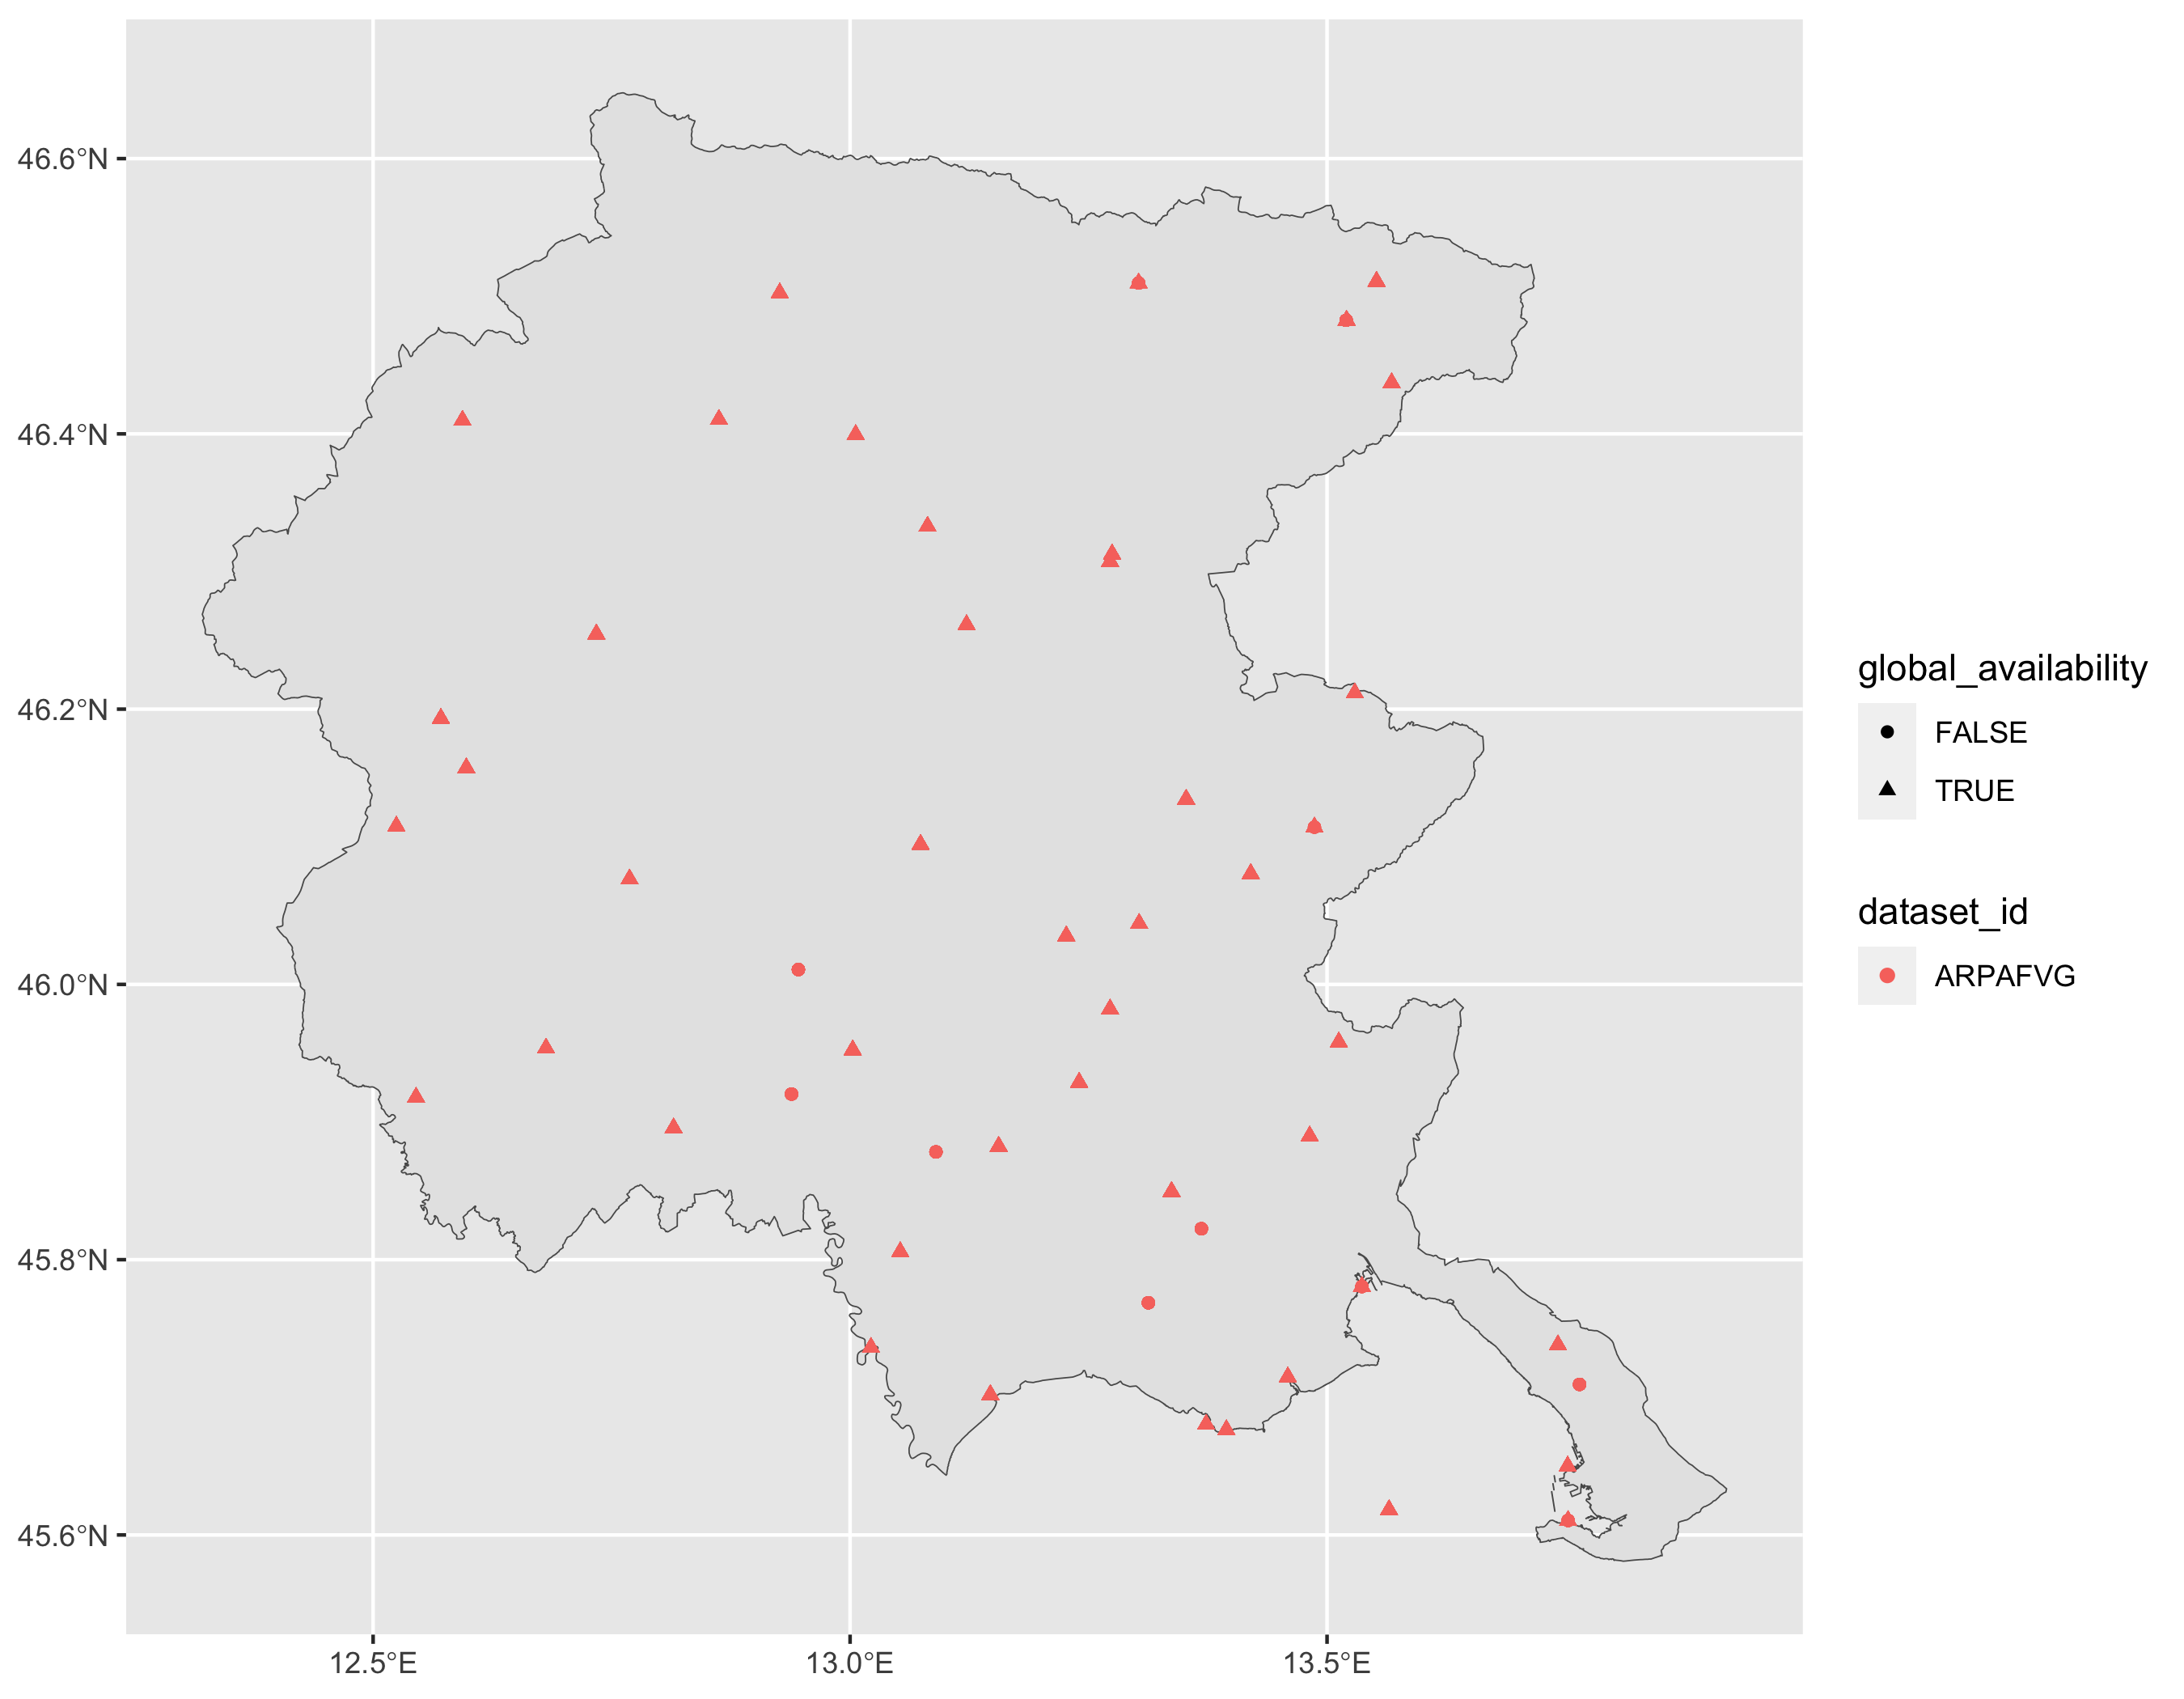

In [14]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, state_boundaries)
p


In [ ]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [44]:
# qc_state <- open_checkpoint(dataset_id, "qc1")
qc_dpc <- open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries |> sf::st_buffer(dist = units::set_units(2, "km")))
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries |> sf::st_buffer(dist = units::set_units(2, "km")))
analysis_results <- perform_analysis(
    qc_dpc,
    qc_scia,
    dist_km = 7,
    first_date,
    last_date,
    "FVG",
)

rm(qc_scia)
rm(qc_dpc)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2347324,125.4,6945902,371.0,NA,6945902,371.0
Vcells,12811477,97.8,260811469,1989.9,16384,363014165,2769.6


In [45]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,270
FALSE,TRUE,583
TRUE,FALSE,310
TRUE,TRUE,5


station_id.x,n
<chr>,<int>
05bb6e98d1727c9f7d79731a07349694,4
0a822df8271eb1b7d33b6d4728ac0054,4
110d01fcfa097906bce5aa39f3d6cb15,4
112c1a9810775ef3b78cd54863b85bff,4
15b822cde80256f377e9426276ed64a2,4
1844630b751d0301235bb41b53cf4dd3,4
27179f7951ef2bfade6f49534d1a9a9b,4
2f564d1dd09889c21276ce5d961e0607,4
700d453c734b854f13f0d2af203b54a4,4


station_id.y,n
<chr>,<int>
127a645989c3c7aa86181f63a6e49029,4
214b5a6ad7db7913d4a9d36924528764,1
2d9211fbc2a2e37885b3fc98afac3a22,4
97caf9880e846fdeebd6471f61957812,4
c1a4834995035d0c6277b18be3a7a599,4
eb5edd3b3f273171037ec7e573083c46,4


In [46]:
combination_results <- build_combined_database(analysis_results, checks = TRUE, test_bounds = 5)
checkpoint_database(combination_results$database, dataset_id, "merged_isac_scia")
save_match_list(combination_results$match_list, dataset_id, "merged_isac_scia")


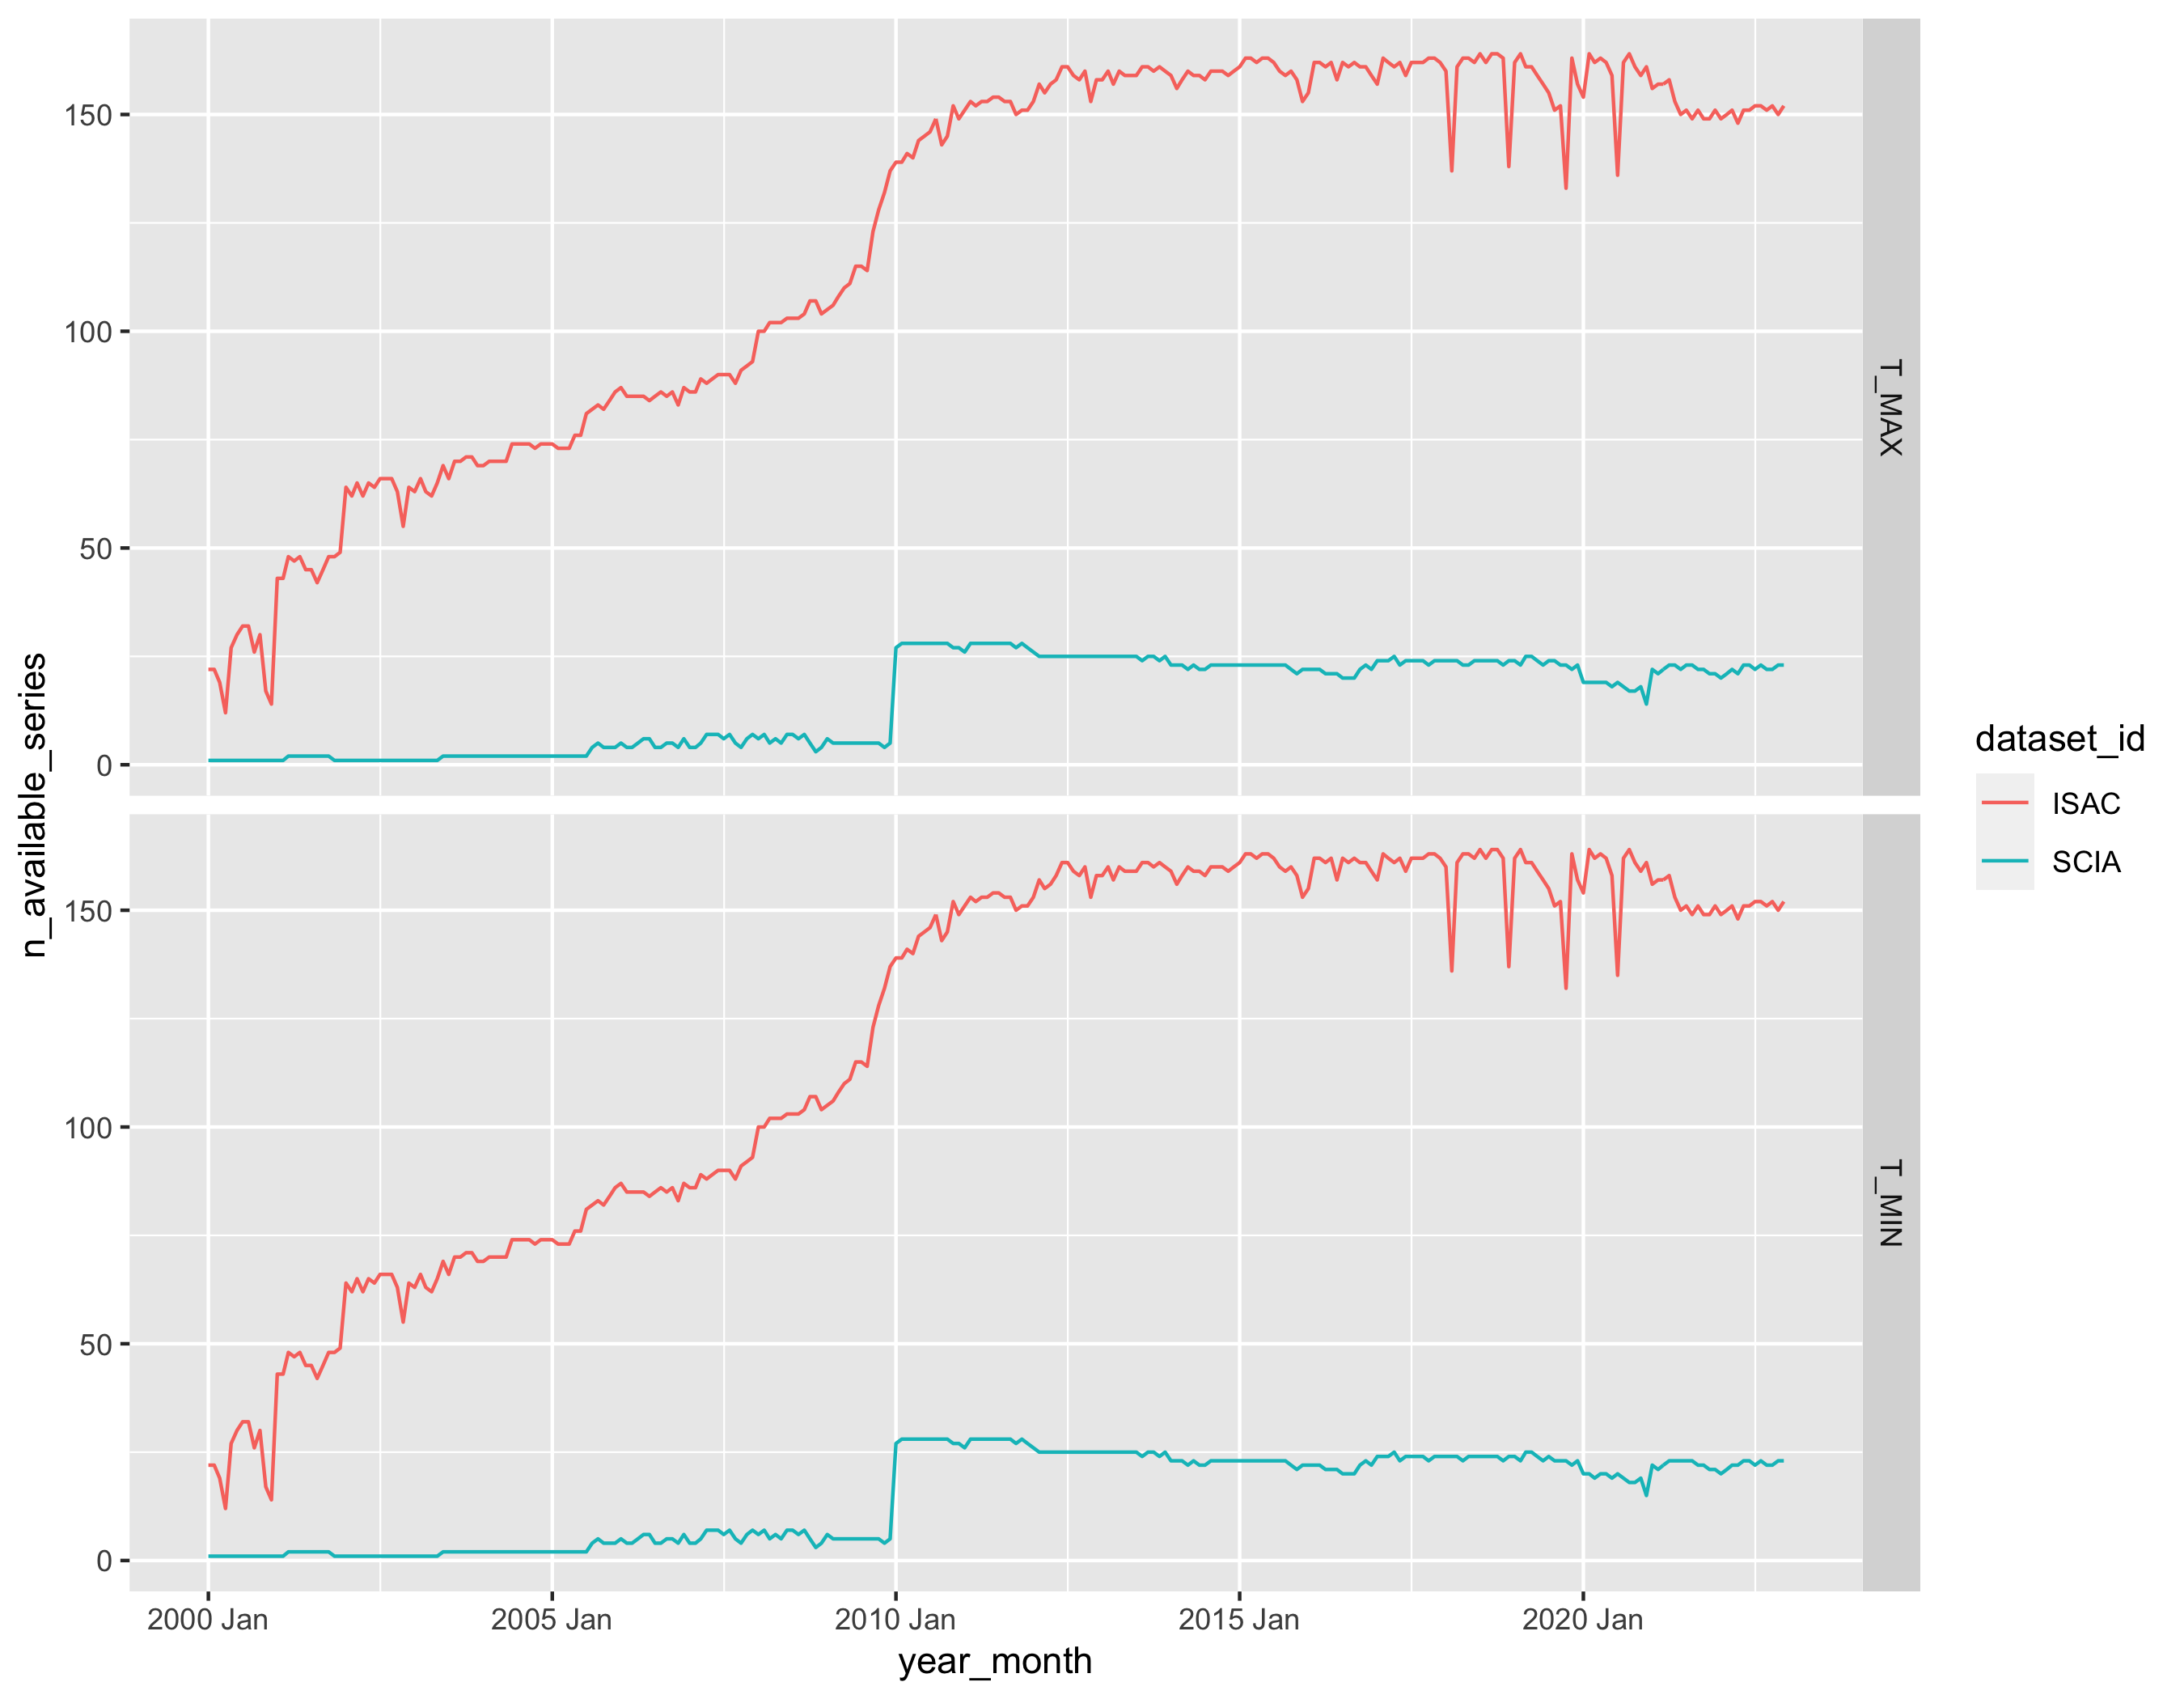

In [47]:
combined_database <- open_checkpoint(dataset_id, "merged_isac_scia")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


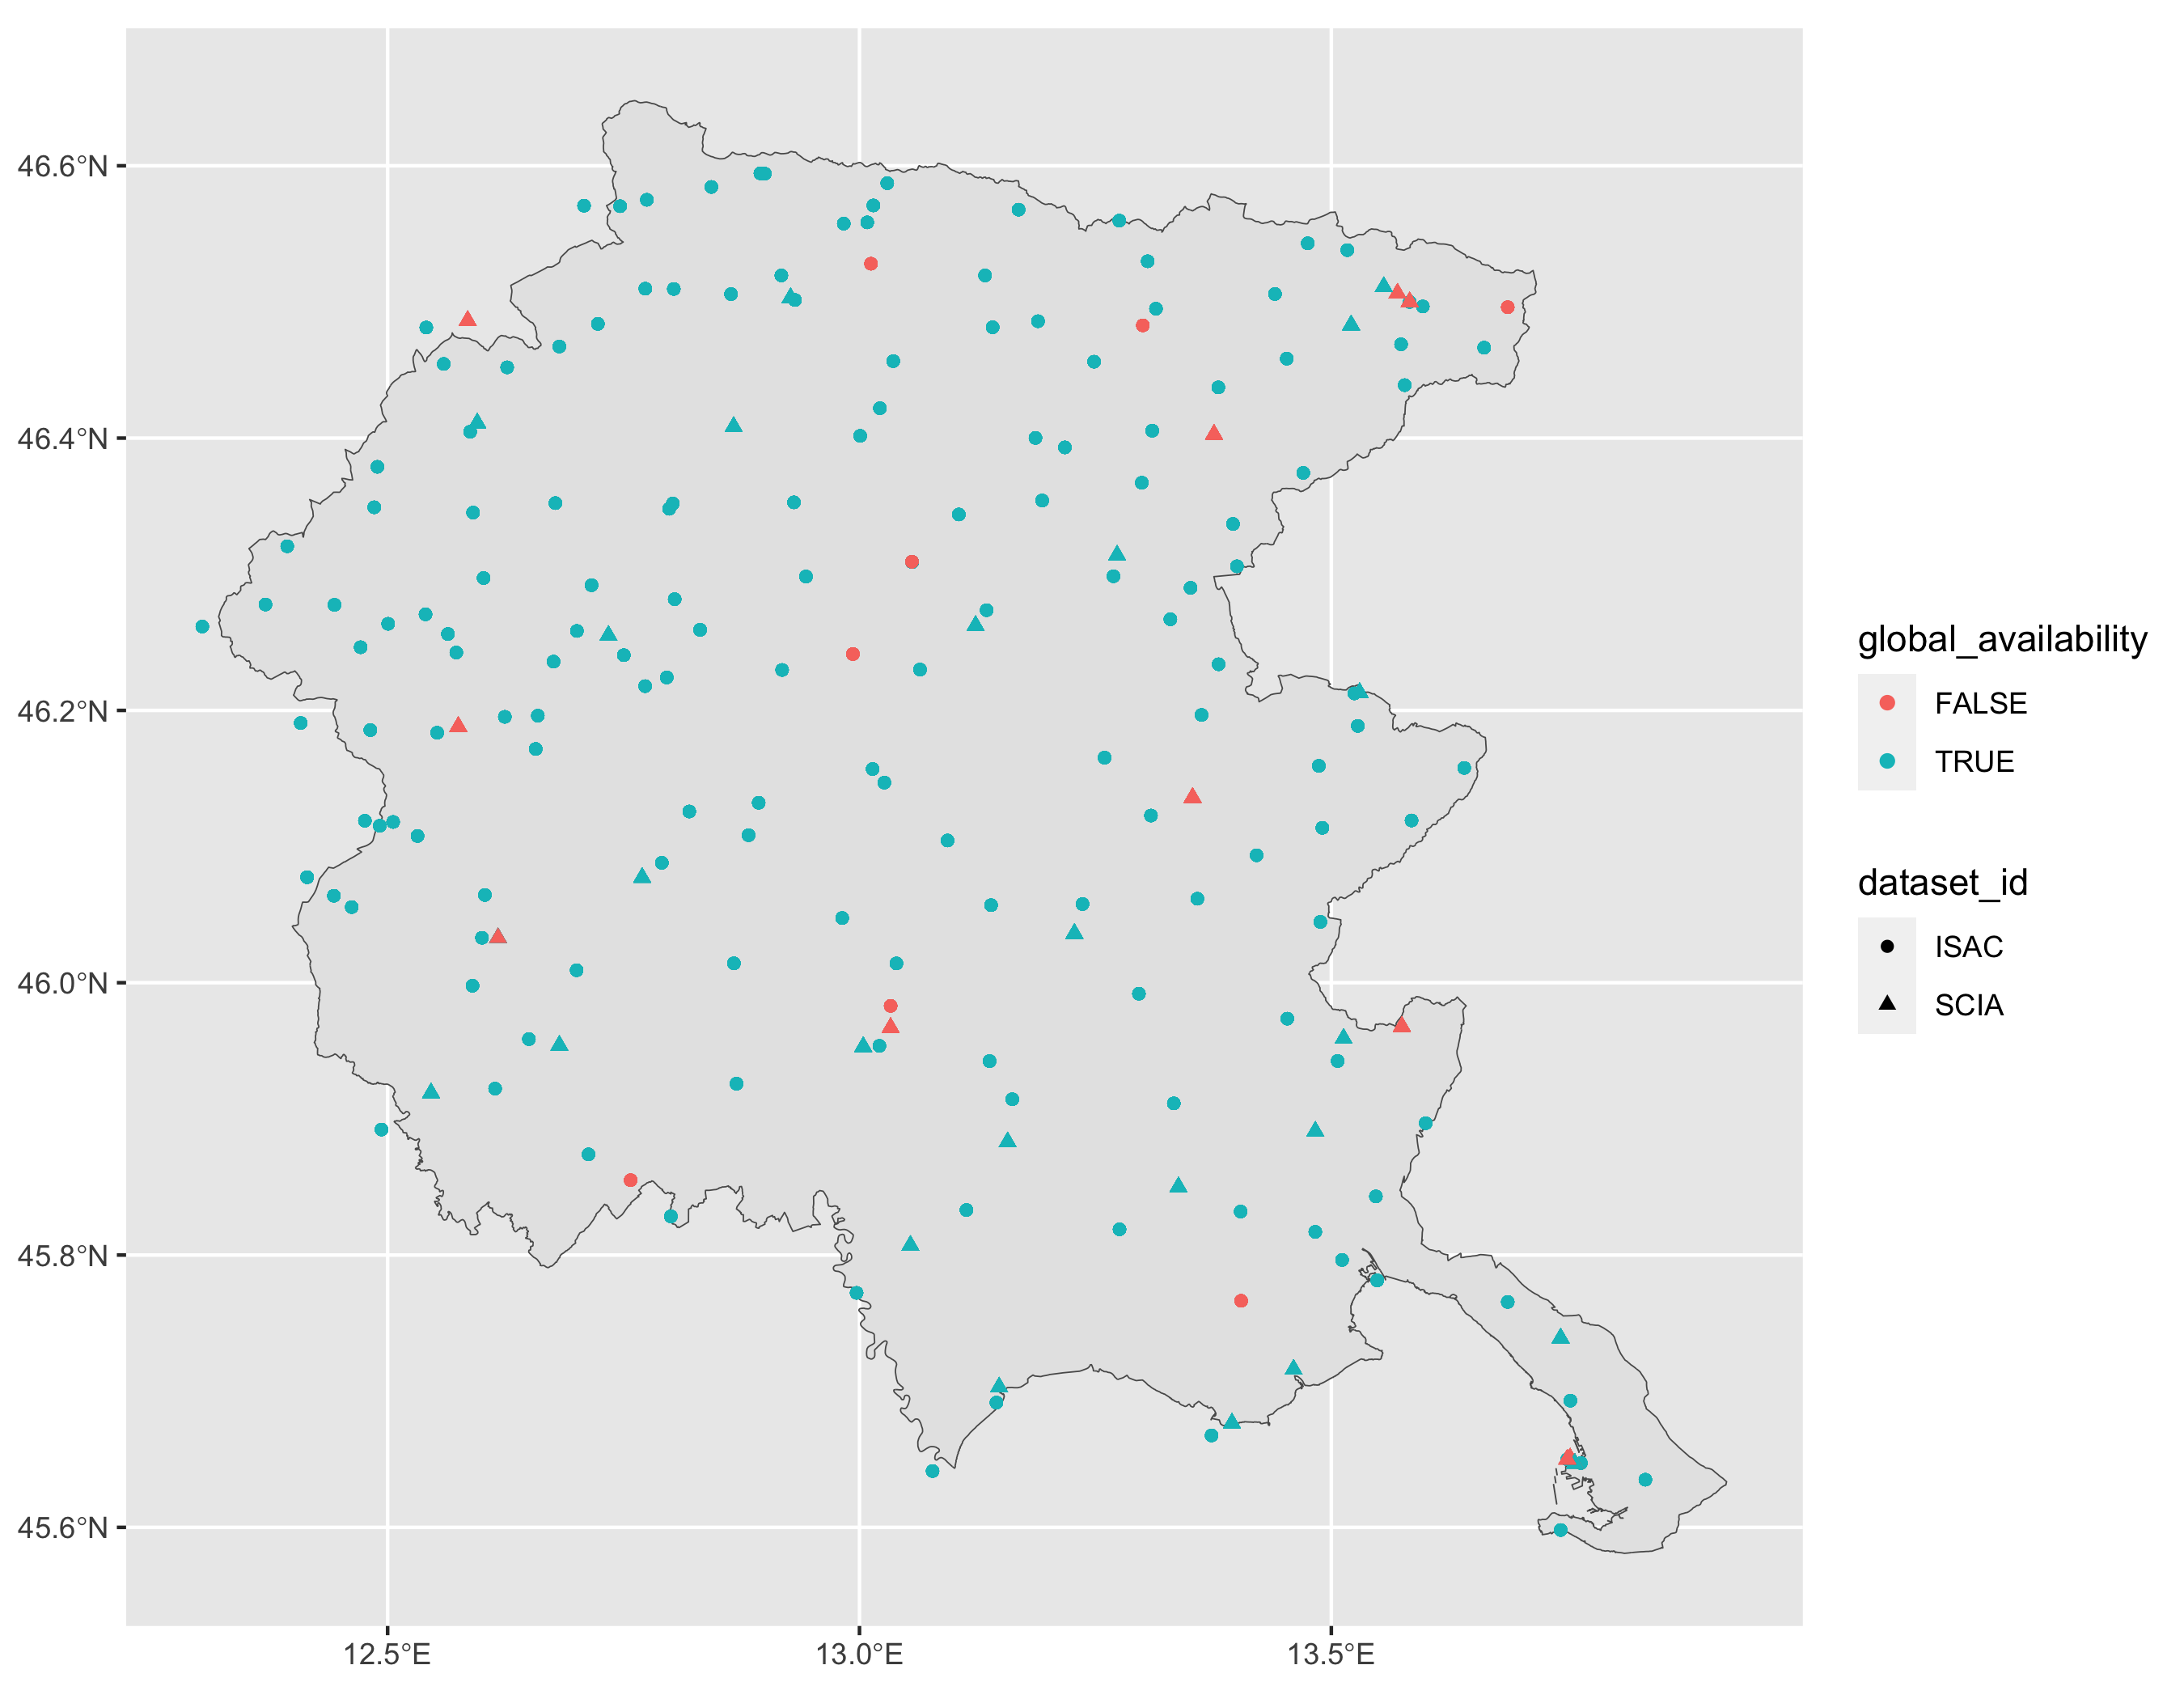

In [48]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [49]:
rm(ymonthly_avail)
rm(climats)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2348971,125.5,6945902,371.0,NA,6945902,371.0
Vcells,14654024,111.9,208649176,1591.9,16384,363014165,2769.6


In [50]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_isacscia <- open_checkpoint(dataset_id, "merged_isac_scia") |> filter_checkpoint_inside(state_boundaries |> sf::st_buffer(dist = units::set_units(2, "km")))
analysis_results <- perform_analysis(
    qc_state,
    qc_isacscia,
    dist_km = 10,
    first_date,
    last_date,
    "FVG",
)

Data prepared. Launching analysis...

In [52]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_arpa_merged, "unusable" = tag_unusable_arpa_merged))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)

same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,230
FALSE,TRUE,334
TRUE,FALSE,104
TRUE,TRUE,21


station_id.x,n
<chr>,<int>
0aa8f79b1259b335bf36901e4143e8d7,6
0d25ae1f40385b74c2057cfadc33f697,4
24aaa82a829e441ae75a569741b77871,4
33891f880311da91beb2e75be083db77,6
36f6a0fc0ca2e38e89cbe1ab82a4505c,4
5a18f715cdb2ef7b67f5147823763c75,4
61f2cf2542a781489e9ed58b3dd59a92,4
6cafaed960b7a8406ddf074f6a0899ef,4
875a44075b84b3c471fa0355b49dc26a,4


station_id.y,n
<chr>,<int>
214b5a6ad7db7913d4a9d36924528764,1
4c201528eced7ad0cfe5297bbd31d4f7,4
82eb05f8e61f9c1e0e7b4f9a5c6d14f6,4
a45c5ae8fa156a88ae1b55ef33c9bb08,4
b35c6ef3bb1a79ff1cba8b5c427f1e8a,1
e934686b104870047c0ca24bac5ebd0f,4
f98b4e99e2302ebe5929f52314363290,4
fdef58ebf1f73d6cc233e3ff56558ab4,3


In [53]:
combination_results <- build_combined_database(analysis_results, checks = TRUE, test_bounds = 5)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")


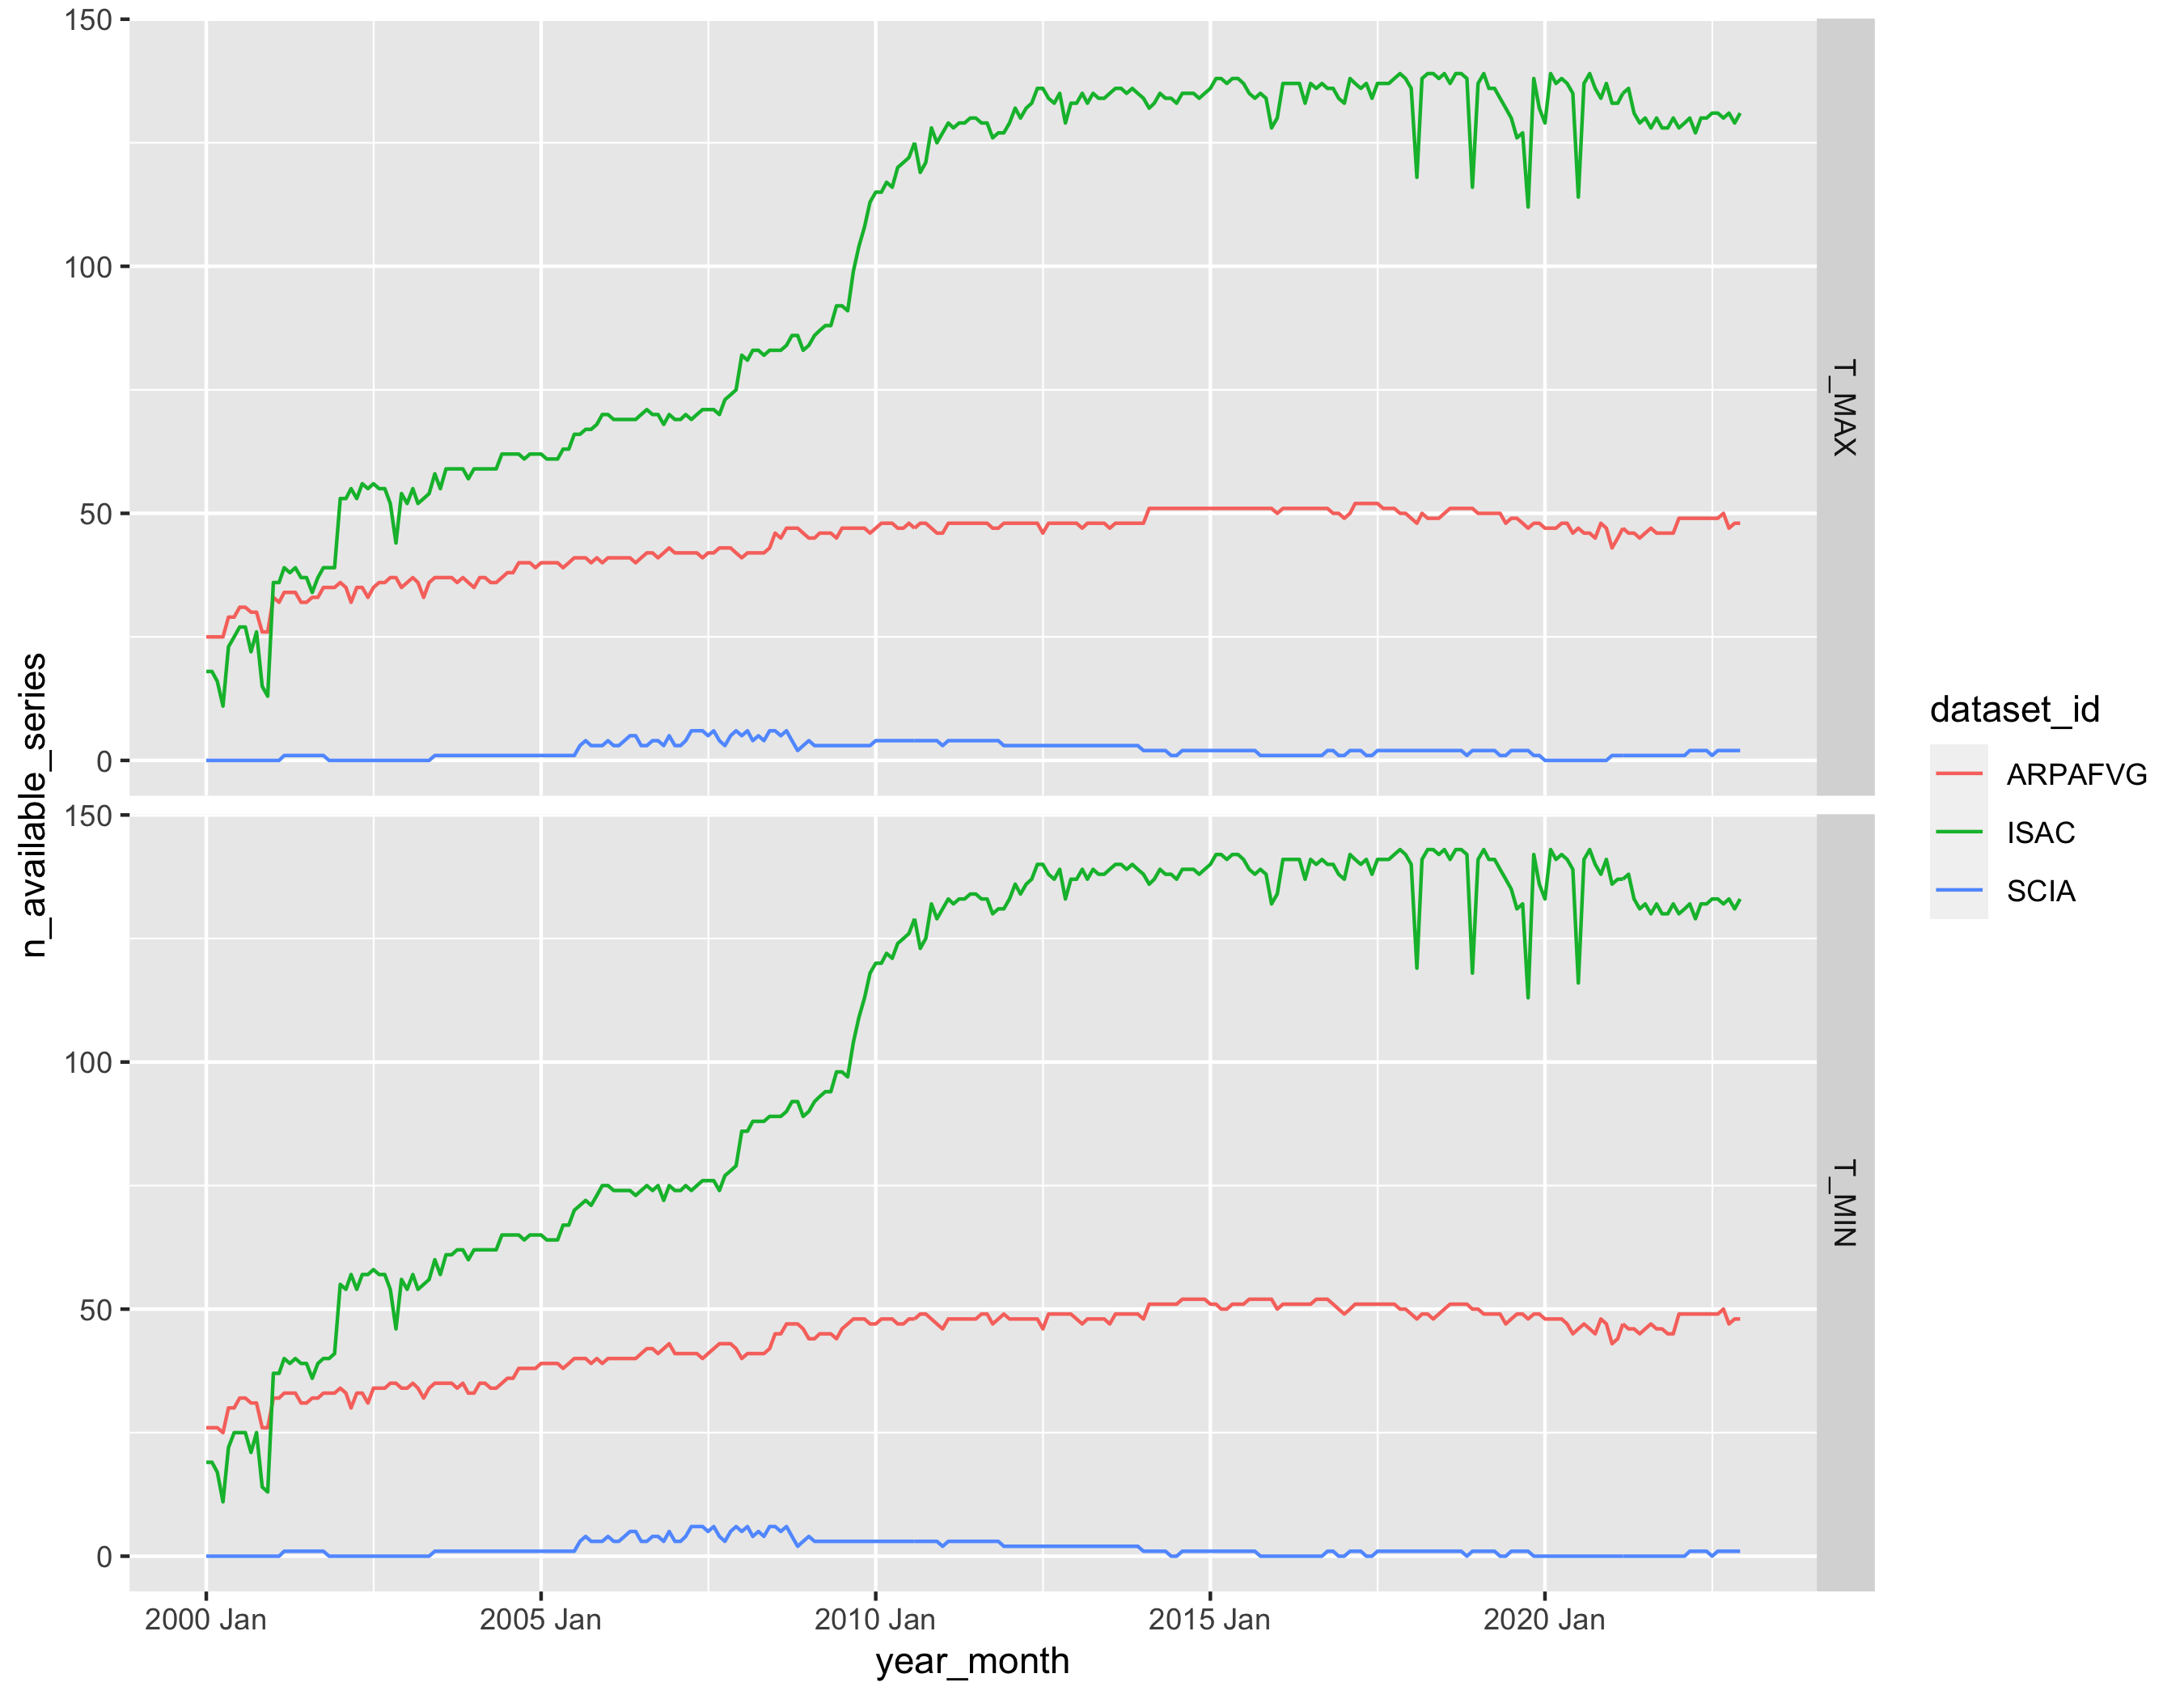

In [3]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

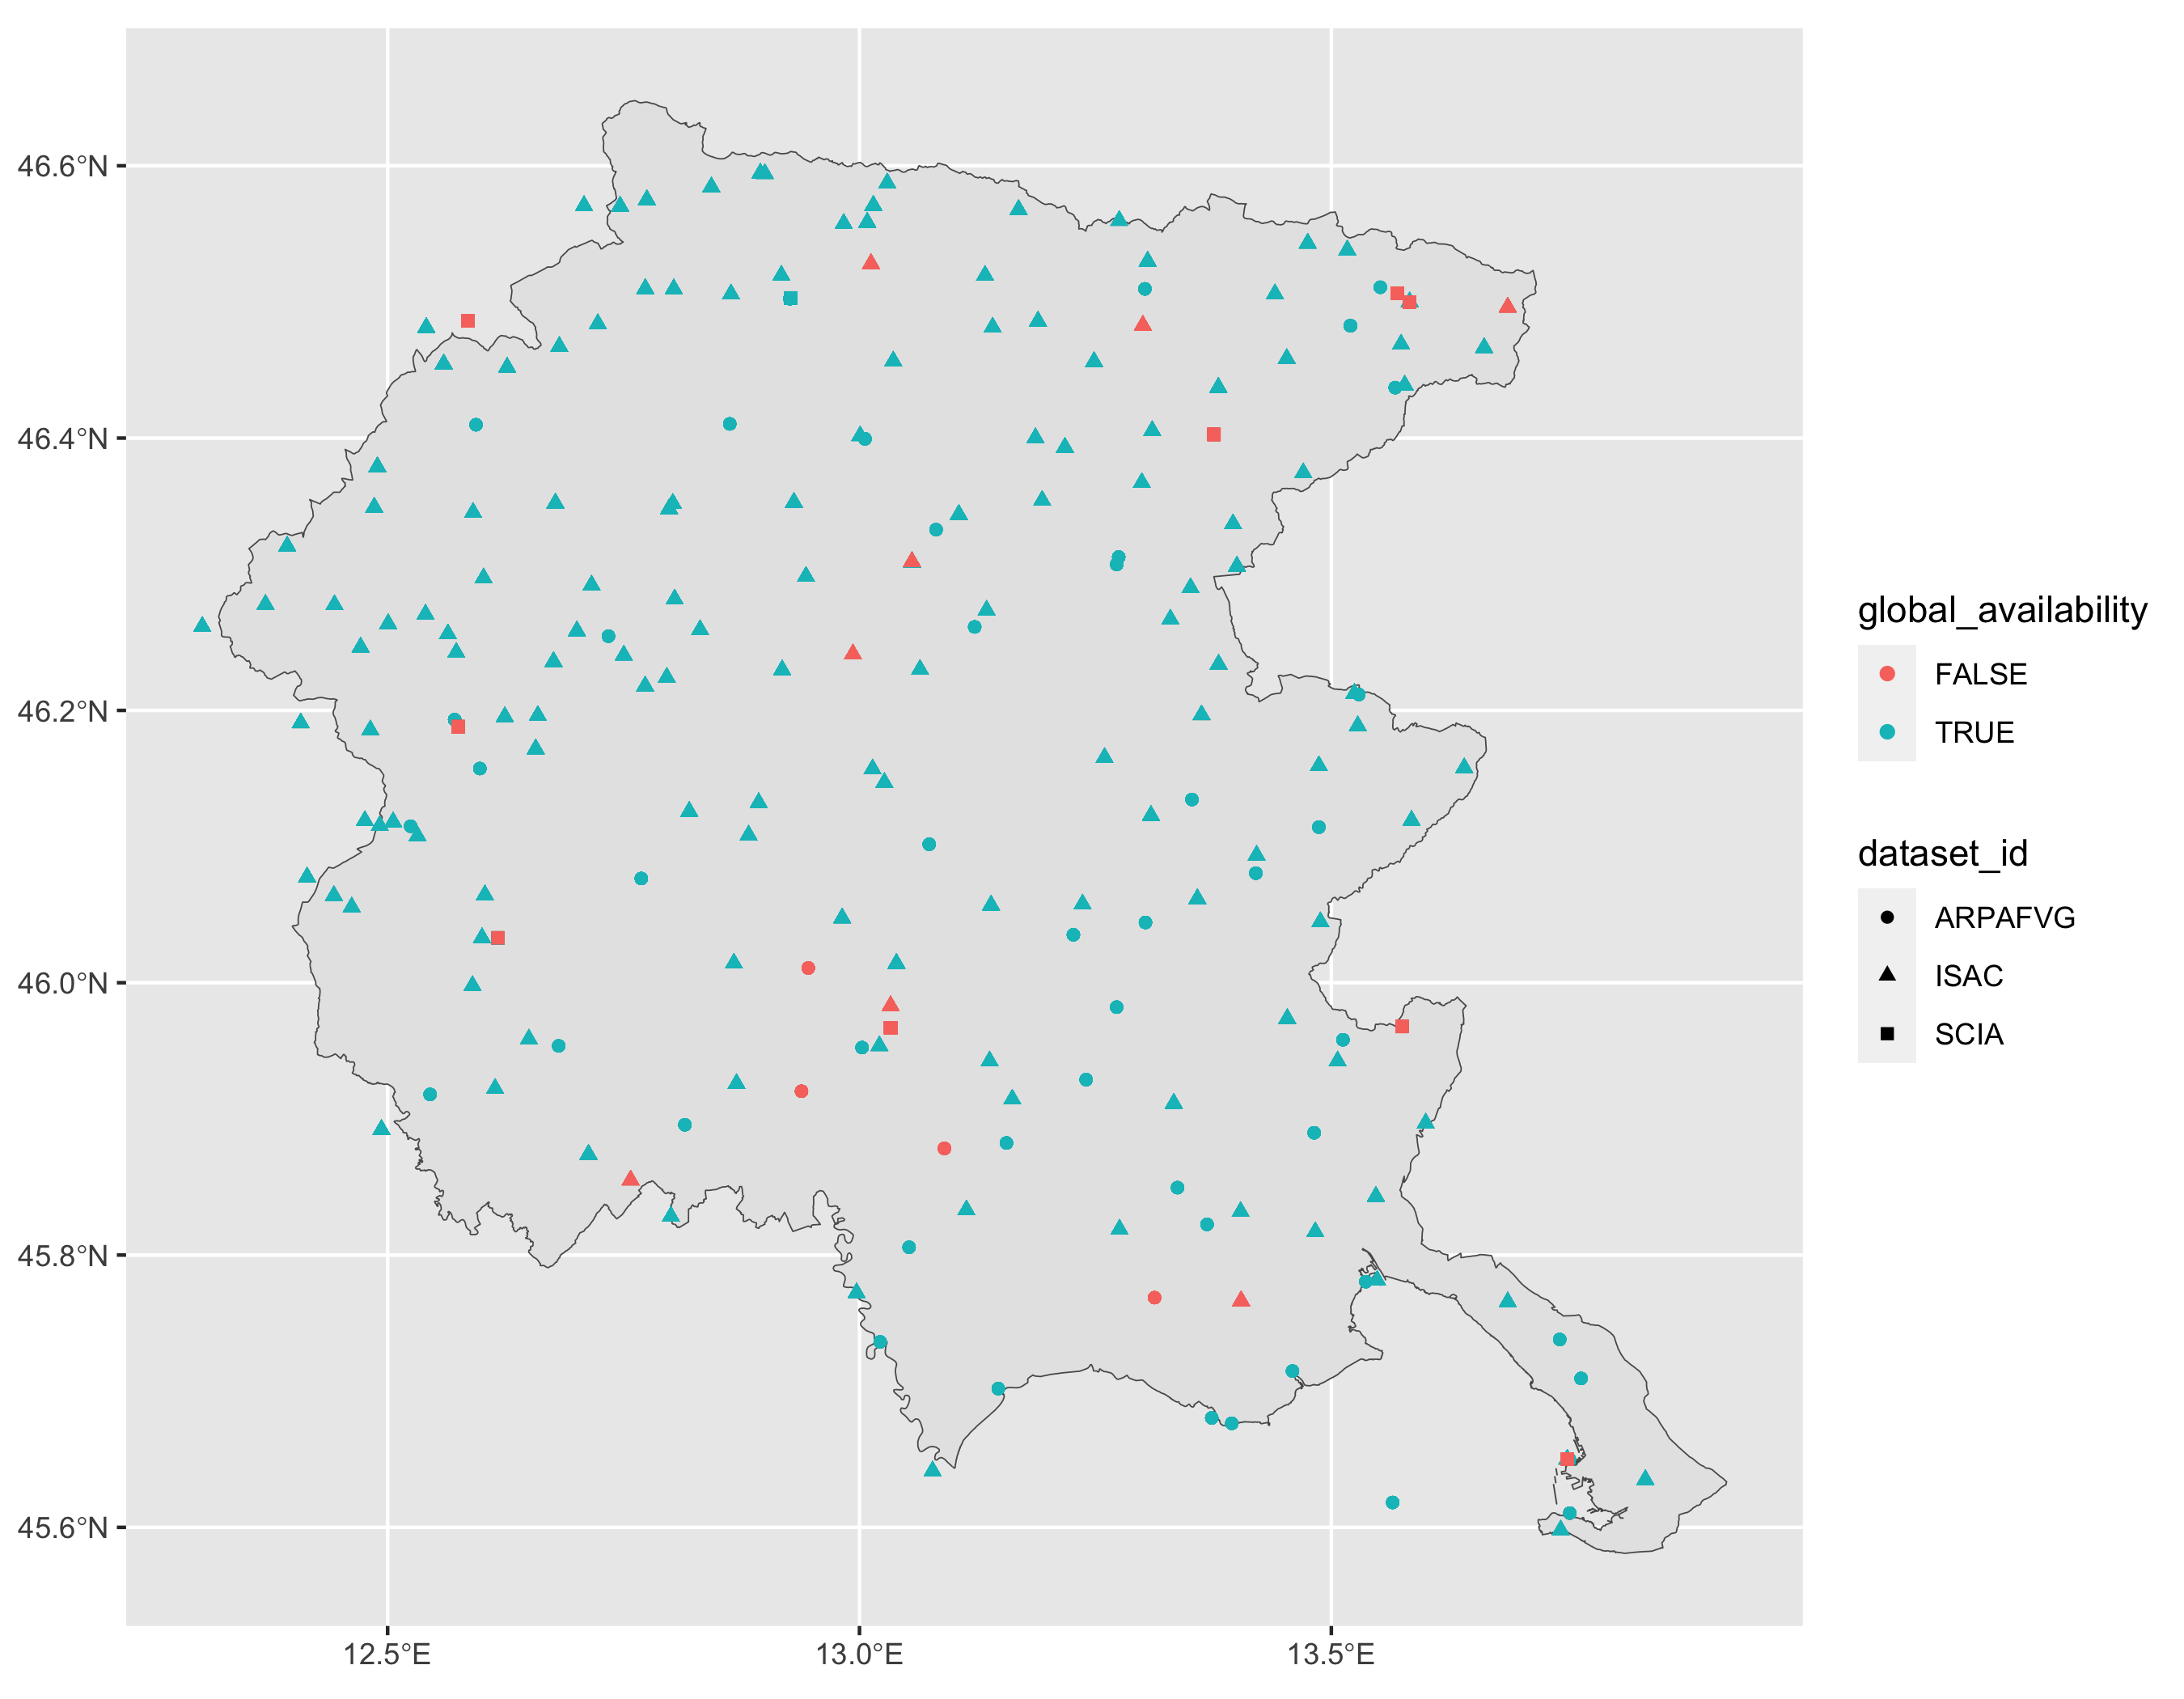

In [55]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [5]:
print("Number of rows:")
combined_database$data |> distinct(station_id, variable) |> compute() |> nrow()

[1] "Number of rows:"


[1] 410

In [ ]:
rm(combined_database)
gc()

In [ ]:
# Launch in an R terminal to see an interactive map
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
combined_database <- open_checkpoint(dataset_id, "merged_isac_scia")
launch_leaflet(combined_database)